# SHAP Analysis

In [12]:
import shap

import numpy as np
import pandas as pd

from xgboost import XGBClassifier
from sklearn.model_selection import KFold, train_test_split

import matplotlib.pyplot as plt
from matplotlib.patches import Patch

In [5]:
# import datasets
y = pd.read_csv('y.csv')
df_basic = pd.read_csv('df_basic.csv')
df_basic_financial = pd.read_csv('df_basic_financial.csv')
df_basic_macroecon = pd.read_csv('df_basic_macroecon.csv')
df_basic_financial_macroecon = pd.read_csv('df_basic_financial_macroecon.csv')

In [6]:
# mapping for renaming columns
columns_old_to_new = {
    'CREATIVEWORKFORCE': 'Creative_Workforce',
    'RUCC': 'RUCC',
    'AGE': 'Population_Age',
    'INCOMELEVEL': 'Income_Level',
    'BACHELOREDUCATION': 'Education_Level',
    'POPULATION': 'Total_Population',
    'MINIMUMSIZE': 'Min_Inv_Size',
    'RAISEDCOMMISSION': 'Commission_Fee',
    'EQUITYCOMMISSION': 'Equity_Stake_Fee',
    'PLATFORMPOPULARITY': 'Platform_Poplarity',
    'DURATION': 'Duration',
    'COMPETITORSCOUNT': 'Total_Competitors',
    'LOCALCOMPETITORSCOUNT': 'Local_Competitors',
    'FINALOFFERINGAMOUNT': 'Target_Offering',
    'FINALSECURITYOFFEREDTYPE_Debt': 'Debt_Security',
    'FINALSECURITYOFFEREDTYPE_Equity': 'Equity_Security',
    'FINALSECURITYOFFEREDTYPE_Other': 'Other_Security',
    'FINALSECURITYOFFEREDTYPE_SAFE': 'SAFE_Security',
    'IS_PRICEMETHOD': 'Price_Method',
    'IS_COVID': 'Covide_Period',
    'IS_POSTREGCHANGE': 'Reg_Amendment',
    'COMPANYAGE': 'Company_Age',
    'PASTCOMPANYSUCCESS': 'Past_CF_Success',
    'PASTCOMPANYFAILURE': 'Past_CF_Failure',
    'PASTPERSONSUCCESS': 'Past_Person_Success',
    'PASTPERSONFAILURE': 'Past_Person_Failure',
    'CURRENTEMPLOYEES': 'Total_Employees',
    'ISDELAWARE': 'Delaware_Inc',
    'IS_EARLY': 'Dev_Early',
    'IS_ESTABLISHED': 'Dev_Established',
    'IS_SCALINGSTRAIN': 'Dev_Scaling_strain',
    'IS_SCALINGEFFICIENT': 'Dev_Scaling_eff',
    'WORKINGCAPITAL': 'Working_Capital',
    'REVENUE': 'Revenue',
    'REVENUEGROWTH': 'Revenue_Growth',
    'DEBTTOASSET': 'Debt_to_Asset',
    'ROA': "ROA",
    'ASSET': 'Asset',
    'CASH': 'Cash',
    'LONGTERMDEBT': 'Long_Term_Debt',
    'NETINCOME': 'Net_Income',
    'GROSSPROFIT': 'Gross_Profit',
    'GROSSMARGIN': 'Gross_Margin',
    'NETPROFITMARGIN': 'Net_Profit_Margin',
    'CASHRUNWAY': 'Cashrunway',
    'UNEMPLOYMENTRATE': 'Unemployment_Rate',
    'AVERAGEINTERESTRATE': 'Interest_Rate',
    'INFLATIONRATE': 'Inflation_Rate',
    'EX_UNEMPLOYMENTRATE': 'Ex_Unemployment',
    'EX_SPOTINTERESTRATE': 'Ex_Interest',
    'EX_INFLATIONRATE': 'Ex_price',
    'EPU': 'EPU',
    'CONSUMERSENTIMENT': 'Consumer_Sentiment',
    'VIX': 'VIX',
    'SNP': 'S&P500_Ret',
    'GINI': 'Gini',
    'GPR': 'GPR',
    'HPI': 'HPI'
}

In [7]:
# rename columns
df_basic = df_basic.rename(columns=columns_old_to_new)
df_basic_financial = df_basic_financial.rename(columns=columns_old_to_new)
df_basic_macroecon = df_basic_macroecon.rename(columns=columns_old_to_new)
df_basic_financial_macroecon = df_basic_financial_macroecon.rename(columns=columns_old_to_new)

In [8]:
# store column names based on feature sets
basic_cols = list(columns_old_to_new.values())[:32]
financial_cols = list(columns_old_to_new.values())[32:45]
economic_cols = list(columns_old_to_new.values())[46:]

## Basic Features

In [28]:
def xgboost_abs_shap(df, y, n_estimators, learning_rate, max_depth, min_child_weight, gamma, subsample, colsample_bytree, colsample_bylevel, reg_lambda):
    '''
    Compute mean absolute SHAP values for an XGBoost classifier with K-fold CV.
    For each fold: train on train-split, compute SHAP on the test-split,
    average |SHAP| across test samples, then average across folds.
    
    Input
    -----
    df: features
    y: target variables
    Other input parameters are the XGBoost hyper-params
    
    Output
    ------
    imp (df.DataFrame): the average absolute SHAP value for each feature
    
    '''
    # define the XGBoost model
    xgb_model = XGBClassifier(
        objective ='binary:logistic',
        use_label_encoder = False,
        eval_metric = 'logloss',
        n_estimators = n_estimators,
        learning_rate = learning_rate,
        max_depth = max_depth,
        min_child_weight = min_child_weight,
        gamma = gamma,
        subsample = subsample,
        colsample_bytree = colsample_bytree,
        colsample_bylevel = colsample_bylevel,
        reg_lambda = reg_lambda,
        random_state=123
    )

    # k-fold cross-validation
    n_splits = 5
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=123)

    # store absolute SHAP values
    abs_shaps = np.zeros(df.shape[1])
    
    for train_idx, test_idx in kfold.split(df):
        X_train, X_test = df.iloc[train_idx], df.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        # train model
        xgb_model.fit(X_train, y_train)

        # SHAP values
        explainer = shap.TreeExplainer(xgb_model)
        shap_values = explainer.shap_values(X_test)

        # Mean absolute SHAP value for this fold
        abs_shaps += np.abs(shap_values).mean(axis=0)

    # average over folds
    abs_shaps /= n_splits

    imp = pd.DataFrame({
        "feature": df.columns,
        "mean_abs_shap": abs_shaps
    }).sort_values("mean_abs_shap", ascending=False).reset_index(drop=True)

    return imp

In [161]:
def plot_shap_barchart(shap_df, basic_cols, financial_cols, economic_cols, set_name, top_n=20):
    """
    Plot a horizontal bar chart of mean absolute SHAP values.

    Input
    -----
    shap_df : DataFrame from xgboost_abs_shap(), must have columns 'feature' and 'mean_abs_shap'.
    basic_cols: list of columns names of basic features
    financial_cols: list of columns names of financial features
    economic_cols: list of columns names of economic features
    set_name: name of the feature set
    top_n : Number of top features to plot (default=20)
    """
    # sort the dataframe
    shap_df = shap_df.sort_values("mean_abs_shap", ascending=True)
    
    # Take top n features
    top_features = shap_df.tail(top_n)

    # Assign colors based on feature set
    colors = []
    for feat in top_features['feature']:
        if feat in basic_cols:
            colors.append('steelblue')   # Basic features
        elif feat in financial_cols:
            colors.append('darkorange') # Financial features
        elif feat in economic_cols:
            colors.append('seagreen')   # Macroeconomic features
        else:
            colors.append('gray')       # For unexpected features
    
    # plot bar chart
    plt.figure(figsize=(14,10))
    bars = plt.barh(top_features["feature"], top_features["mean_abs_shap"], color=colors)
    
    # Add annotations to each bar
    for bar, value in zip(bars, top_features["mean_abs_shap"]):
        plt.text(value,
                 bar.get_y() + bar.get_height()/2,
                 f"{value:.4f}",
                 va="center",
                 ha="left",
                 fontsize=12)
    
    # add legend
    legend_elements = []
    if 'basic' in set_name.lower():
        legend_elements.append(Patch(facecolor='steelblue', label='Basic Features'))
    if 'finan' in set_name.lower():
        legend_elements.append(Patch(facecolor='darkorange', label='Financial Features'))
    if 'macro' in set_name.lower():
        legend_elements.append(Patch(facecolor='seagreen', label='Macroeconomic Features'))
    
    # legend_elements = [
    #     Patch(facecolor='steelblue', label='Basic Features'),
    #     Patch(facecolor='darkorange', label='Financial Features'),
    #     Patch(facecolor='seagreen', label='Macroeconomic Features')
    # ]
    plt.legend(handles=legend_elements, title="Feature Set", fontsize=12, title_fontsize=13)
    
    plt.xlabel("Mean |SHAP value|", fontsize=15)
    plt.ylabel("Feature", fontsize=15)
    plt.title(f"Top {top_n} Features by Mean Absolute SHAP Value in {set_name} Feature Set", fontsize=15)
    plt.tight_layout()
    plt.show()

In [30]:
def plot_bee_swarm(df, y, n_estimators, learning_rate, max_depth, min_child_weight, gamma, subsample, colsample_bytree, colsample_bylevel, reg_lambda):
    '''
    Compute SHAP values with K-fold CV for an XGBoost classifier,
    and plot a SHAP beeswarm.
    '''
    # pre-allocate Out-of-Fold (OOF) SHAP array: one row per sample, one column per feature
    n_samples, n_features = df.shape
    oof_shap = np.zeros((n_samples, n_features))

    # create a copy, to used by summary_plot for coloring
    X_full = df.copy()

    # K-fold CV, fill OOF SHAP rows by test indices
    kf = KFold(n_splits=5, shuffle=True, random_state=123)

    for train_idx, test_idx in kf.split(df):
        X_train, X_test = df.iloc[train_idx], df.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        model = XGBClassifier(
            objective='binary:logistic',
            use_label_encoder=False,
            eval_metric='logloss',
            n_estimators=n_estimators,
            learning_rate=learning_rate,
            max_depth=max_depth,
            min_child_weight=min_child_weight,
            gamma=gamma,
            subsample=subsample,
            colsample_bytree=colsample_bytree,
            colsample_bylevel=colsample_bylevel,
            reg_lambda=reg_lambda,
            random_state=123
        )
        model.fit(X_train, y_train)

        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(X_test) # this returns an array with the shape: (n_test, n_features)

        # store OOF SHAP in the rows corresponding to this test fold
        oof_shap[test_idx, :] = shap_values

    # plot bee-swarm chart
    shap.summary_plot(oof_shap, X_full) # Plot the top 20 features (default setttings)
    plt.show()

In [76]:
# compute SHAP values
abs_shaps_basic = xgboost_abs_shap(
                                    df=df_basic,
                                    y=y,
                                    n_estimators=100,
                                    learning_rate=0.01,
                                    max_depth=10,
                                    min_child_weight=1,
                                    gamma=5,
                                    subsample=1,
                                    colsample_bytree=0.6,
                                    colsample_bylevel=0.6,
                                    reg_lambda=1
                                )

C:\Users\User\OneDrive\Desktop\lib\site-packages\xgboost\training.py:183: UserWarning: [23:55:38] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\User\OneDrive\Desktop\lib\site-packages\xgboost\training.py:183: UserWarning: [23:55:39] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\User\OneDrive\Desktop\lib\site-packages\xgboost\training.py:183: UserWarning: [23:55:39] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\User\OneDrive\Desktop\lib\site-packages\xgboost\training.py:183: UserWarning: [23:55:39] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not

In [87]:
abs_shaps_basic

,feature,mean_abs_shap
0,Target_Offering,0.257435
1,Price_Method,0.217907
2,Platform_Poplarity,0.148922
3,Equity_Stake_Fee,0.094758
4,Duration,0.064498
5,Commission_Fee,0.055136
6,Debt_Security,0.052940
7,Min_Inv_Size,0.026316
8,SAFE_Security,0.022306
9,Total_Competitors,0.017270


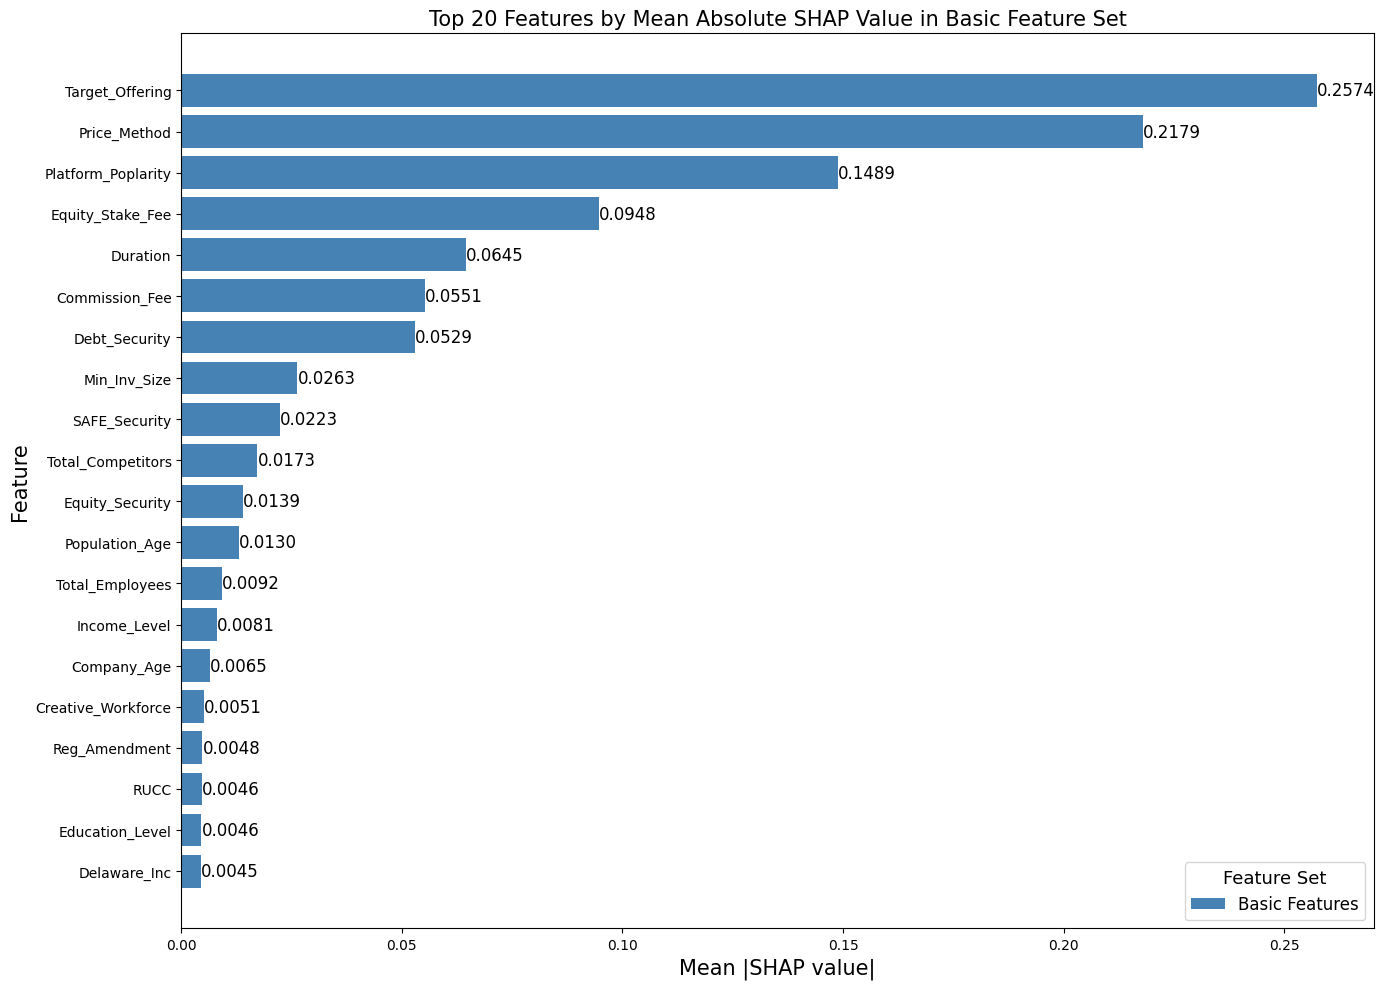

In [163]:
# plot mean abs SHAP
plot_shap_barchart(abs_shaps_basic, basic_cols, financial_cols, economic_cols, 'Basic', 20)

C:\Users\User\OneDrive\Desktop\lib\site-packages\xgboost\training.py:183: UserWarning: [16:09:41] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\User\OneDrive\Desktop\lib\site-packages\xgboost\training.py:183: UserWarning: [16:09:41] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\User\OneDrive\Desktop\lib\site-packages\xgboost\training.py:183: UserWarning: [16:09:41] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\User\OneDrive\Desktop\lib\site-packages\xgboost\training.py:183: UserWarning: [16:09:41] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not

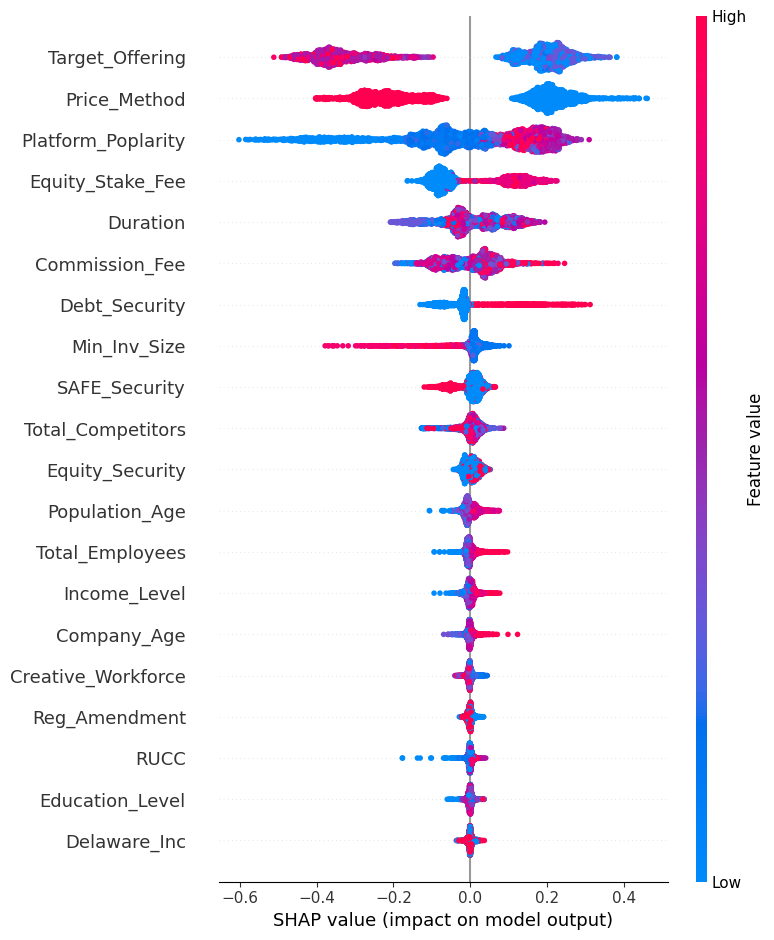

In [31]:
# Plot bee-swarm chart
plot_bee_swarm(
    df=df_basic,
    y=y,
    n_estimators=100,
    learning_rate=0.01,
    max_depth=10,
    min_child_weight=1,
    gamma=5,
    subsample=1,
    colsample_bytree=0.6,
    colsample_bylevel=0.6,
    reg_lambda=1
)

## Basic + Financial Features

In [78]:
# compute SHAP values
abs_shaps_basic_financial = xgboost_abs_shap(
                                    df=df_basic_financial,
                                    y=y,
                                    n_estimators=100,
                                    learning_rate=0.01,
                                    max_depth=7,
                                    min_child_weight=5,
                                    gamma=0.1,
                                    subsample=0.8,
                                    colsample_bytree=0.6,
                                    colsample_bylevel=0.6,
                                    reg_lambda=1
                                )

C:\Users\User\OneDrive\Desktop\lib\site-packages\xgboost\training.py:183: UserWarning: [23:55:41] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\User\OneDrive\Desktop\lib\site-packages\xgboost\training.py:183: UserWarning: [23:55:41] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\User\OneDrive\Desktop\lib\site-packages\xgboost\training.py:183: UserWarning: [23:55:41] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\User\OneDrive\Desktop\lib\site-packages\xgboost\training.py:183: UserWarning: [23:55:42] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not

In [79]:
abs_shaps_basic_financial.head(20)

,feature,mean_abs_shap
0,Target_Offering,0.248700
1,Price_Method,0.227133
2,Platform_Poplarity,0.125771
3,Equity_Stake_Fee,0.087199
4,Duration,0.066694
5,Commission_Fee,0.056871
6,Debt_Security,0.048766
7,Min_Inv_Size,0.028178
8,Net_Income,0.021524
9,Asset,0.019987


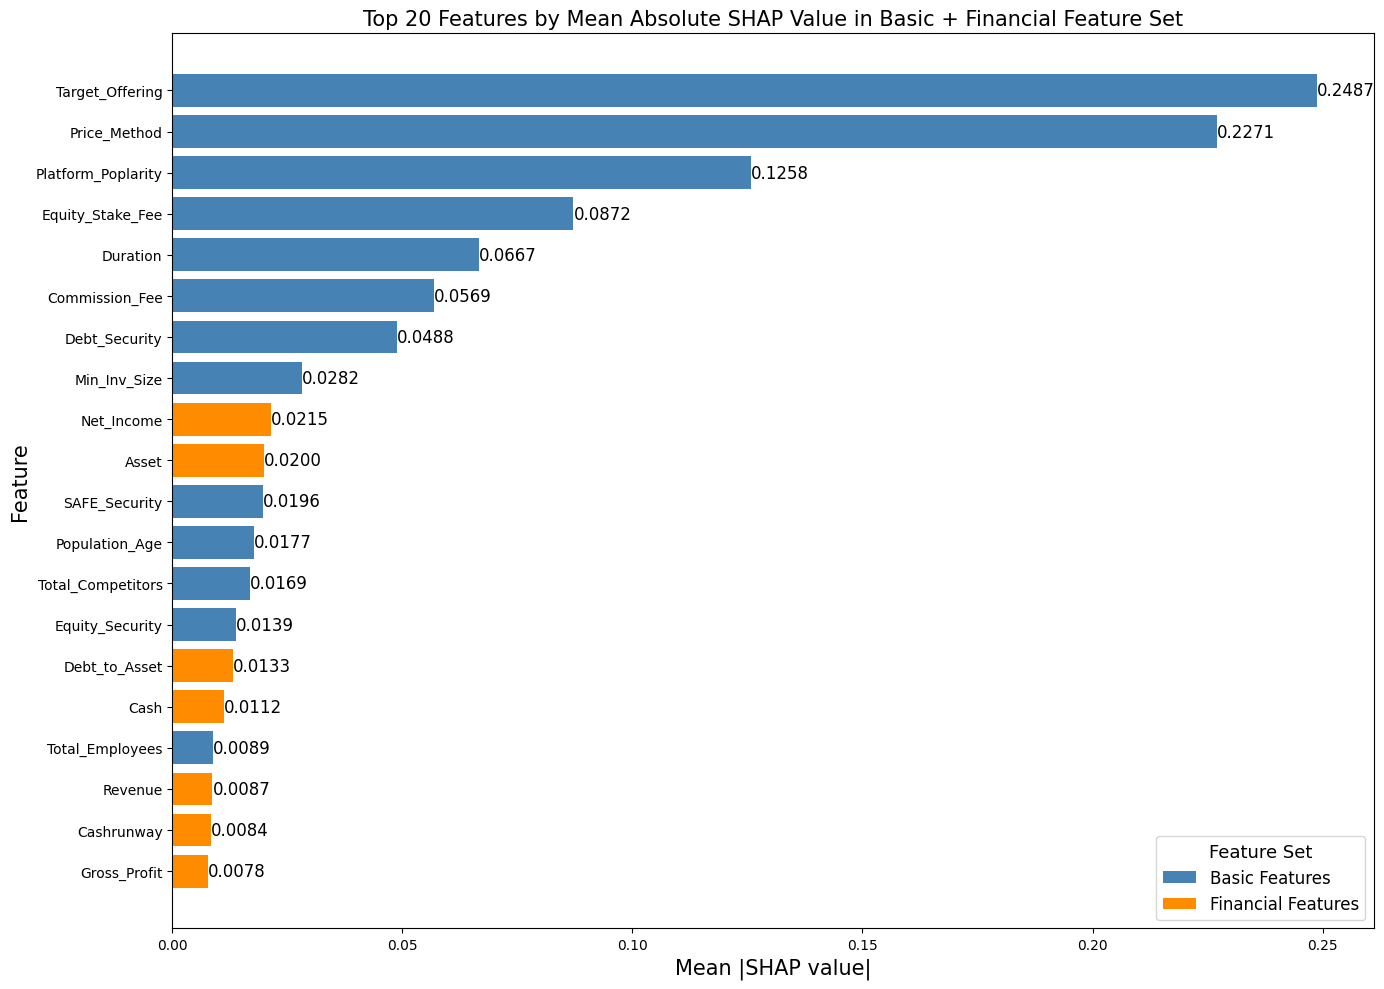

In [164]:
# plot mean abs SHAP
plot_shap_barchart(abs_shaps_basic_financial, basic_cols, financial_cols, economic_cols, 'Basic + Financial', 20)

C:\Users\User\OneDrive\Desktop\lib\site-packages\xgboost\training.py:183: UserWarning: [16:14:09] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\User\OneDrive\Desktop\lib\site-packages\xgboost\training.py:183: UserWarning: [16:14:09] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\User\OneDrive\Desktop\lib\site-packages\xgboost\training.py:183: UserWarning: [16:14:10] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\User\OneDrive\Desktop\lib\site-packages\xgboost\training.py:183: UserWarning: [16:14:10] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not

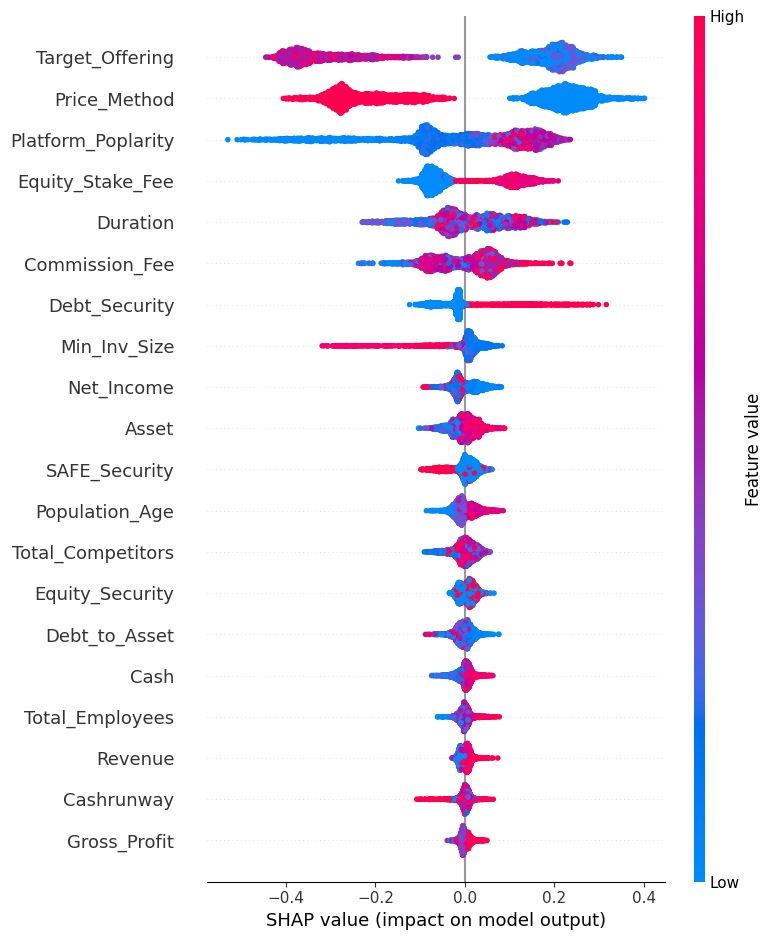

In [32]:
# Plot bee-swarm chart
plot_bee_swarm(
    df=df_basic_financial,
    y=y,
    n_estimators=100,
    learning_rate=0.01,
    max_depth=7,
    min_child_weight=5,
    gamma=0.1,
    subsample=0.8,
    colsample_bytree=0.6,
    colsample_bylevel=0.6,
    reg_lambda=1
)

## Basic + Macroeconomic Features

In [81]:
# compute SHAP values
abs_shaps_basic_macroecon = xgboost_abs_shap(
                                    df=df_basic_macroecon,
                                    y=y,
                                    n_estimators=100,
                                    learning_rate=0.01,
                                    max_depth=7,
                                    min_child_weight=5,
                                    gamma=0.1,
                                    subsample=0.8,
                                    colsample_bytree=0.6,
                                    colsample_bylevel=0.6,
                                    reg_lambda=1
                                )

C:\Users\User\OneDrive\Desktop\lib\site-packages\xgboost\training.py:183: UserWarning: [23:55:43] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\User\OneDrive\Desktop\lib\site-packages\xgboost\training.py:183: UserWarning: [23:55:44] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\User\OneDrive\Desktop\lib\site-packages\xgboost\training.py:183: UserWarning: [23:55:44] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\User\OneDrive\Desktop\lib\site-packages\xgboost\training.py:183: UserWarning: [23:55:45] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not

In [82]:
abs_shaps_basic_macroecon.head(20)

,feature,mean_abs_shap
0,Target_Offering,0.248163
1,Price_Method,0.228319
2,Platform_Poplarity,0.130723
3,Equity_Stake_Fee,0.087150
4,Duration,0.067592
5,Commission_Fee,0.058286
6,Debt_Security,0.051047
7,Min_Inv_Size,0.027321
8,SAFE_Security,0.019980
9,Population_Age,0.018894


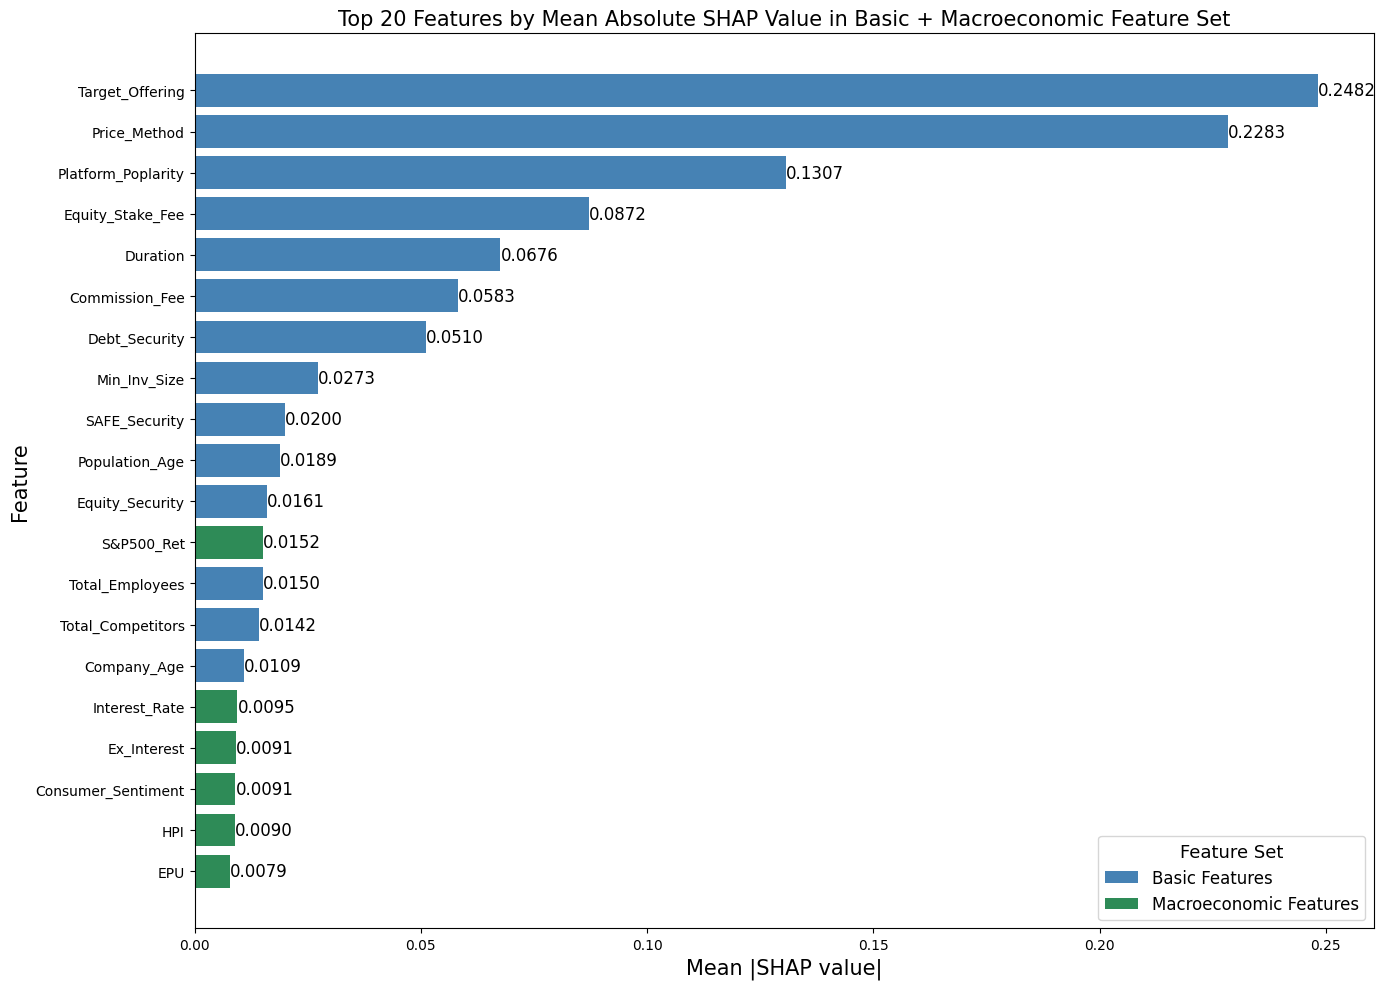

In [165]:
# plot mean abs SHAP
plot_shap_barchart(abs_shaps_basic_macroecon, basic_cols, financial_cols, economic_cols, 'Basic + Macroeconomic', 20)

C:\Users\User\OneDrive\Desktop\lib\site-packages\xgboost\training.py:183: UserWarning: [16:14:17] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\User\OneDrive\Desktop\lib\site-packages\xgboost\training.py:183: UserWarning: [16:14:17] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\User\OneDrive\Desktop\lib\site-packages\xgboost\training.py:183: UserWarning: [16:14:18] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\User\OneDrive\Desktop\lib\site-packages\xgboost\training.py:183: UserWarning: [16:14:18] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not

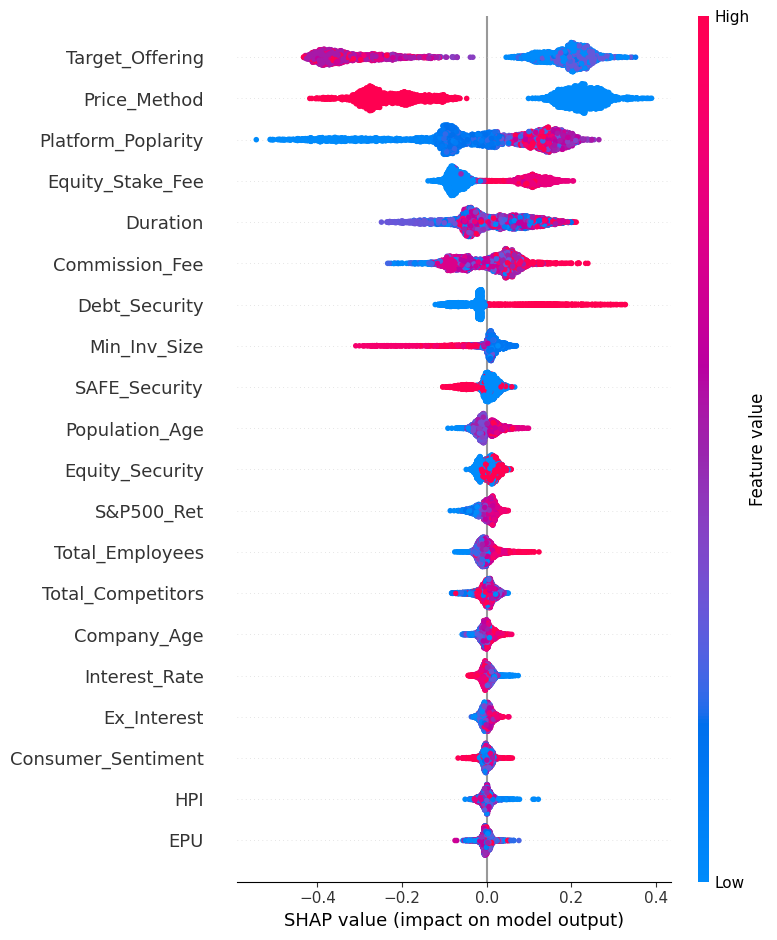

In [33]:
# Plot bee-swarm chart
plot_bee_swarm(
    df=df_basic_macroecon,
    y=y,
    n_estimators=100,
    learning_rate=0.01,
    max_depth=7,
    min_child_weight=5,
    gamma=0.1,
    subsample=0.8,
    colsample_bytree=0.6,
    colsample_bylevel=0.6,
    reg_lambda=1
)

## Basic + Financial + Macroeconomic Features

In [84]:
# compute SHAP values
abs_shaps_basic_financial_macroecon = xgboost_abs_shap(
                                    df=df_basic_financial_macroecon,
                                    y=y,
                                    n_estimators=100,
                                    learning_rate=0.01,
                                    max_depth=10,
                                    min_child_weight=1,
                                    gamma=0,
                                    subsample=0.8,
                                    colsample_bytree=0.8,
                                    colsample_bylevel=0.6,
                                    reg_lambda=1
                                )

C:\Users\User\OneDrive\Desktop\lib\site-packages\xgboost\training.py:183: UserWarning: [23:55:46] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\User\OneDrive\Desktop\lib\site-packages\xgboost\training.py:183: UserWarning: [23:55:47] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\User\OneDrive\Desktop\lib\site-packages\xgboost\training.py:183: UserWarning: [23:55:49] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\User\OneDrive\Desktop\lib\site-packages\xgboost\training.py:183: UserWarning: [23:55:51] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not

In [85]:
abs_shaps_basic_financial_macroecon.head(20)

,feature,mean_abs_shap
0,Target_Offering,0.271733
1,Price_Method,0.260041
2,Platform_Poplarity,0.150675
3,Duration,0.085024
4,Debt_Security,0.075793
5,Equity_Stake_Fee,0.070623
6,Commission_Fee,0.042186
7,Min_Inv_Size,0.024829
8,Net_Income,0.020753
9,Asset,0.017573


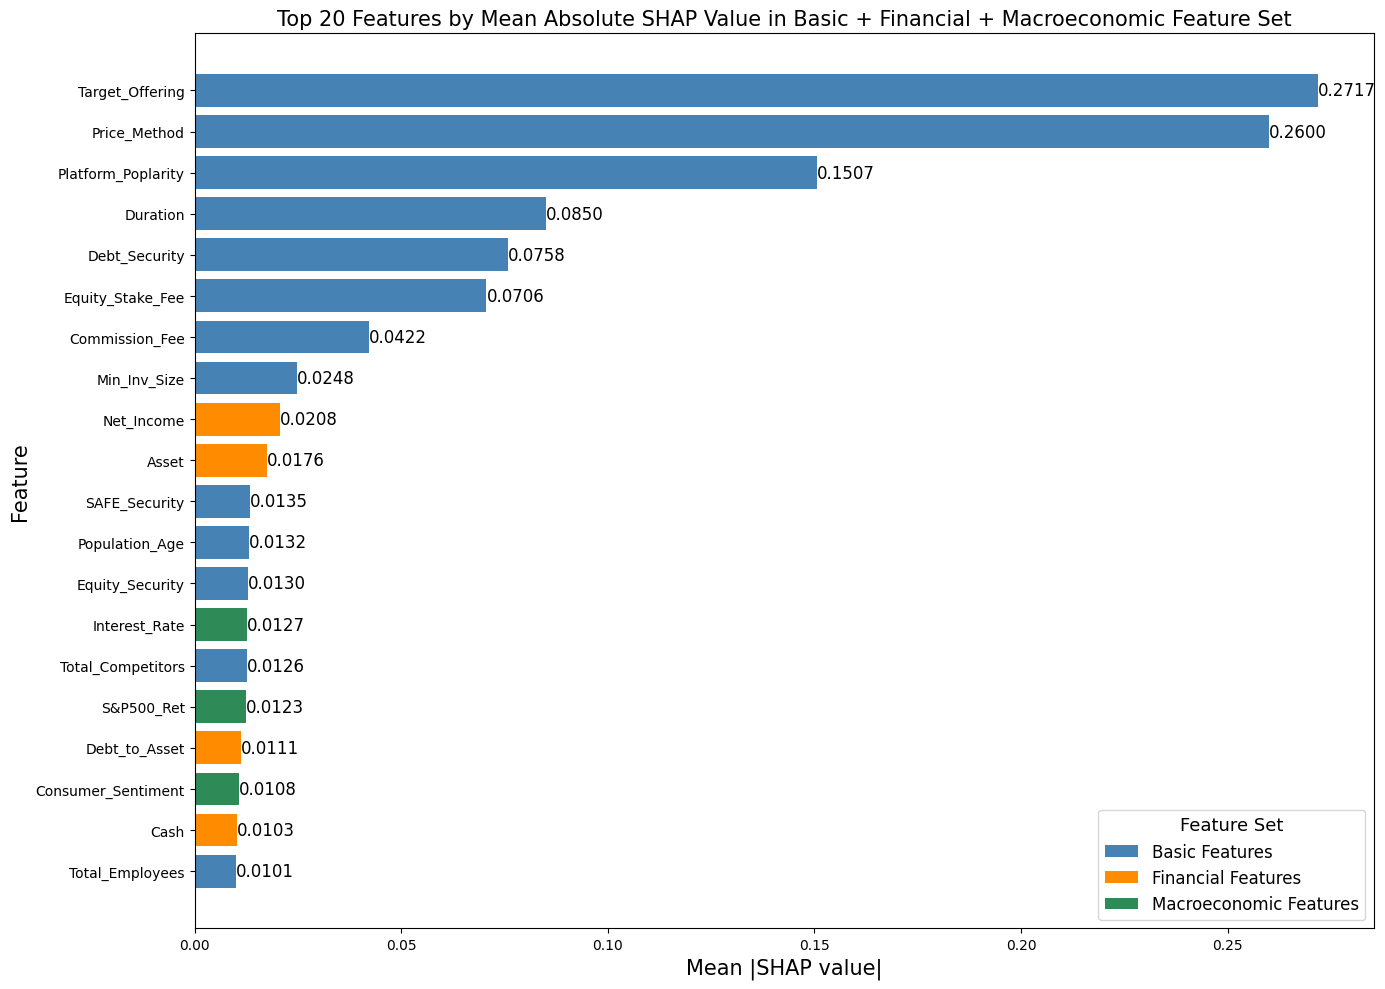

In [167]:
# plot mean abs SHAP
plot_shap_barchart(abs_shaps_basic_financial_macroecon, basic_cols, financial_cols, economic_cols, 'Basic + Financial + Macroeconomic', 20)

In [171]:
# Compute the average SHAP value of the features in the financial and macroeconomic feature sets
top_fin = []
top_econ = []
for i in range(len(abs_shaps_basic_financial_macroecon)):
    if top_n and abs_shaps_basic_financial_macroecon.loc[i,'feature'] in financial_cols:
        top_fin.append(abs_shaps_basic_financial_macroecon.loc[i,'mean_abs_shap'])
    elif abs_shaps_basic_financial_macroecon.loc[i,'feature'] in economic_cols:
        top_econ.append(abs_shaps_basic_financial_macroecon.loc[i,'mean_abs_shap'])

print(sum(top_fin)/len(top_fin))
print(sum(top_econ)/len(top_econ))

0.00992495847436098
0.00834045682180052


C:\Users\User\OneDrive\Desktop\lib\site-packages\xgboost\training.py:183: UserWarning: [16:14:20] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\User\OneDrive\Desktop\lib\site-packages\xgboost\training.py:183: UserWarning: [16:14:22] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\User\OneDrive\Desktop\lib\site-packages\xgboost\training.py:183: UserWarning: [16:14:24] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\User\OneDrive\Desktop\lib\site-packages\xgboost\training.py:183: UserWarning: [16:14:25] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not

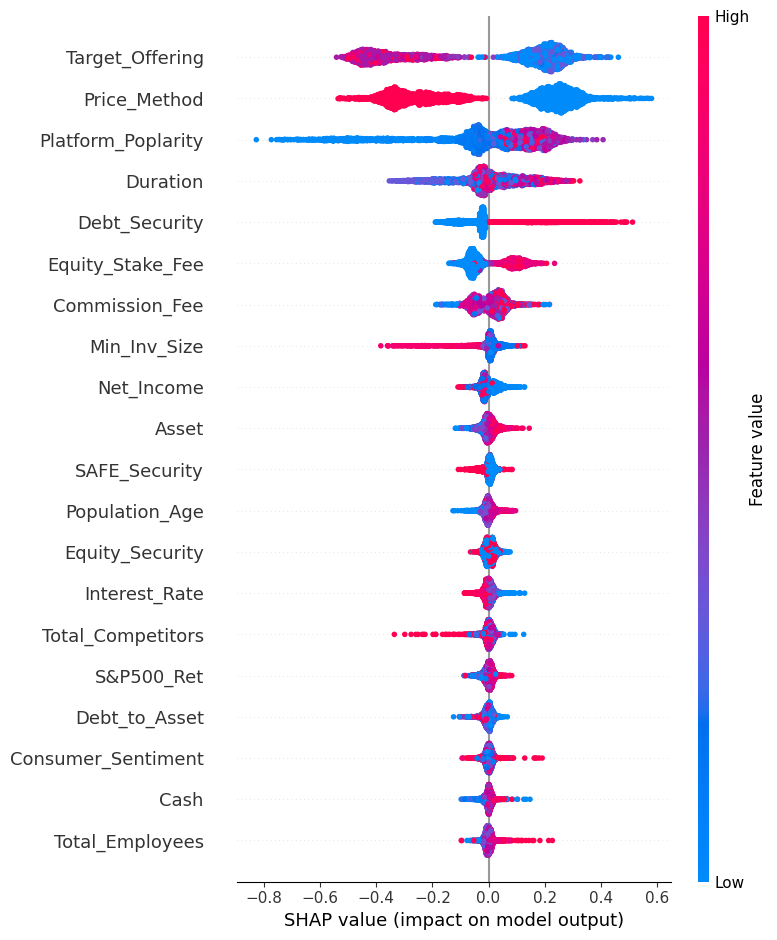

In [34]:
# Plot bee-swarm chart
plot_bee_swarm(
    df=df_basic_financial_macroecon,
    y=y,
    n_estimators=100,
    learning_rate=0.01,
    max_depth=10,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    colsample_bylevel=0.6,
    reg_lambda=1
)